# LDED Audiovisual Fusion 

Author: Chen Lequn.
Created on 3 Oct 2023.

- Material: Maraging Steel 300
- Process: Robotic Laser-directed energy deposition
- Recorded data: position, veolocity, coaxial ccd features, audio feature
- Quality labels generated: keyhole pores, cracks, defect-free

### Notebook 2c: Audio Visual Feature Analysis
- Using the handcrafted features from video and audio stream, fused with location info
- Vision features: melt pool geometric features, including width, length, moment of area, convex hull, etc.
- Audio features: spectral centroid, spectral bandwidth, flux, etc.
- Feature visualization, correlation analysis
- Dimensionality reduction

In [1]:
from sklearnex import patch_sklearn, config_context
# import dpctl
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import itertools
from pandas import DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
# For K Nearest Neighbours:
from sklearn import neighbors
# For support vector machine:
from sklearn import svm
# For Gaussian process:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
# For neural network:
from sklearn.neural_network import MLPClassifier
# For decision tree:
from sklearn import tree
# For plotting the decision tree structure:
# import graphviz
import pickle
# For ensemble methods: random forest ad AdaBoost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# For Naive Bayes method:
from sklearn.naive_bayes import GaussianNB
# For logistic regression:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV  
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
# For plotting
import plotly.io as pio
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt

# For ML model saving
import pickle
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white", palette=None)

In [5]:
import sys
sys.path.insert(0, '../utils')
import glob
import os
# import utils
FRAME_SIZE = 2048
HOP_LENGTH = 512

In [44]:
def plot_data_distribution(data, variable, title, filename, figure_size=(7, 6)):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Create the countplot
    sns.countplot(x=variable, data=data, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Add percentages above each bar
    total = len(data)
    max_height = 0
    for p in ax.patches:
        max_height = max(max_height, p.get_height())
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')
    
    # Extend the y-axis for better visibility of annotations
    ax.set_ylim([0, max_height * 1.2])
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel("Categories", fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Add grid
    ax.grid(True, which='both', axis='y', linestyle='dotted', linewidth=0.5, alpha=0.7, color='black')
    
    # Show all four edges of the plot
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    # Show the plot
    plt.tight_layout()
    save_fig(f"{filename}.png")
    plt.show()

In [7]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'feature_extraction')
os.makedirs(IMAGE_PATH, exist_ok=True)

Multimodal_dataset_PATH = "/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')
                            

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

## Import Extracted features

In [80]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name'])
df_multimodal

,sample index,Time_Stamps,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,rms_energy,amplitude_envelope_mean,...,center_y,contour_area,contour_length,X,Y,Z,Vx,Vy,Vz,Speed
0,1,0.00,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,0.009018,0.003034,...,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,2,0.04,sample_21_2.wav,sample_21_2.jpg,Defect-free,Defect-free,1.0,21,0.019286,0.012109,...,239.000000,305442.0,2234.000000,0.000,-0.000,0.001,-0.074,-0.074,0.000,0.105
2,3,0.08,sample_21_3.wav,sample_21_3.jpg,Defect-free,Defect-free,1.0,21,0.019593,0.015114,...,239.000000,305442.0,2234.000000,-0.010,0.015,-0.007,-0.051,0.026,-0.051,0.077
3,4,0.12,sample_21_4.wav,sample_21_4.jpg,Defect-free,Defect-free,1.0,21,0.030937,0.021501,...,230.264496,291865.5,2279.781744,-0.007,0.016,0.010,0.173,-0.222,2.520,2.536
4,5,0.16,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,0.038329,0.029851,...,229.109962,281970.0,2407.847760,-0.111,0.123,-0.057,-1.864,1.662,-2.468,3.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48461,10982,439.24,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,Laser-off,NaN,26,0.011000,0.009066,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48462,10983,439.28,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,Laser-off,NaN,26,0.008347,0.006188,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48463,10984,439.32,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,Laser-off,NaN,26,0.011081,0.007763,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48464,10985,439.36,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,Laser-off,NaN,26,0.011044,0.007960,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080


In [81]:
df_multimodal['class_name'].unique()

['Laser-off', 'Defect-free', 'Crack', 'Keyhole pores']
Categories (4, object): ['Crack', 'Defect-free', 'Keyhole pores', 'Laser-off']

In [82]:
df_multimodal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32946 entries, 0 to 48465
Columns: 134 entries, sample index to Speed
dtypes: category(4), float32(52), float64(76), int64(2)
memory usage: 31.7 MB


Saving figure dataset_distribution.png


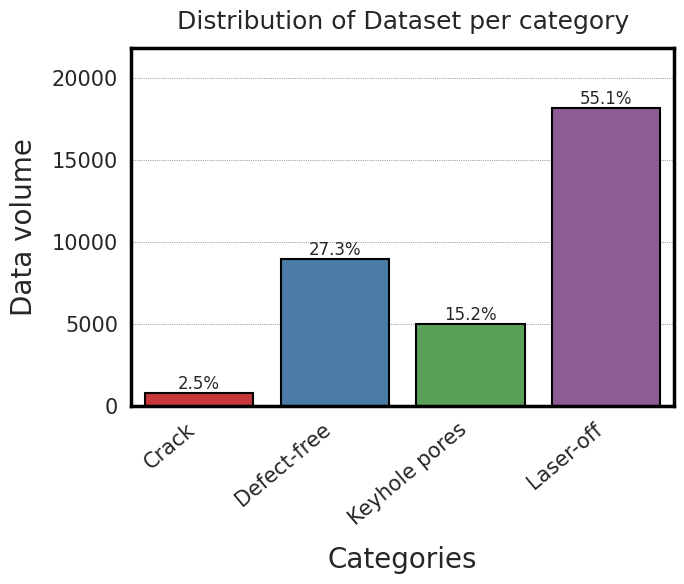

In [83]:
plot_data_distribution(df_multimodal, 'class_name', 
                       'Distribution of Dataset per category', 'dataset_distribution')

In [84]:
df_multimodal.groupby('class_name').describe()

sample index                                                    \
                     count         mean          std     min     25%     50%   
class_name                                                                     
Crack                812.0  6546.780788  4763.708660   228.0  2511.0  5455.5   
Defect-free         8993.0  2515.756255  2364.316854     1.0   729.0  1647.0   
Keyhole pores       4994.0  7134.945735  3714.036675  2959.0  4056.0  4811.5   
Laser-off          18147.0  5139.471042  3332.575143     1.0  2298.5  4682.0   

                                Time_Stamps              ...       Vz  \
                   75%      max       count        mean  ...      75%   
class_name                                               ...            
Crack          8613.75  15716.0       812.0  261.831232  ...  0.25125   
Defect-free    3631.00  11076.0      8993.0  100.590250  ...  0.42800   
Keyhole pores  9954.75  16317.0      4994.0  285.357829  ...  0.39000   
Laser-off      7948.50  15863.0     18147.0  205.538842  ...  0.07400   

                          Speed                                             \
                   max    count       mean        std  min     25%     50%   
class_name                                                                   
Crack            4.888    812.0  19.136622  53.157105  0.0   0.179  24.842   
Defect-free    285.680   8993.0  21.535054  27.971131  0.0  23.494  25.114   
Keyhole pores   14.256   4385.0  19.580708  14.891408  0.0   3.811  25.034   
Laser-off        9.063  18107.0   4.759872   9.844226  0.0   0.091   0.147   

                                  
                   75%       max  
class_name                        
Crack          27.2605  1155.435  
Defect-free    26.8980  1167.800  
Keyhole pores  27.1050   606.184  
Laser-off       0.2670    93.339  

[4 rows x 1040 columns]

# Data feature analysis

## 1. Intra-modality Feature Correlation Analysis: Find the top N correlated features with a given feature 
- If the given feature is from the audio set, only audio features will be considered for correlation.
- If the given feature is from the vision set, only vision features will be considered for correlation.

__Redundant Features__: If multiple features are highly correlated, they often carry the same information. Reducing these can help in preventing multicollinearity in linear models and can also reduce the dimensionality of your data, making models train faster and potentially improving generalization.

It can improve the model's generalization and reduce overfitting. It also makes the model simpler and faster to train.

In [85]:
audio_features = [
        'rms_energy', 'amplitude_envelope_mean','amplitude_envelope_std', 'zero_crossing_rate', 'dynamic_complexity',
        'loudness', 'loudness_vickers', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_complexity_mean',
        'spectral_complexity_std', 'spectral_contrast_0_mean', 'spectral_contrast_0_std', 'spectral_contrast_1_mean',
        'spectral_contrast_1_std', 'spectral_contrast_2_mean', 'spectral_contrast_2_std', 'spectral_contrast_3_mean',
        'spectral_contrast_3_std', 'spectral_contrast_4_mean', 'spectral_contrast_4_std', 'spectral_contrast_5_mean',
        'spectral_contrast_5_std', 'spectral_valley_0_mean', 'spectral_valley_0_std', 'spectral_valley_1_mean',
        'spectral_valley_1_std', 'spectral_valley_2_mean', 'spectral_valley_2_std', 'spectral_valley_3_mean',
        'spectral_valley_3_std', 'spectral_valley_4_mean','spectral_valley_4_std', 'spectral_valley_5_mean',
        'spectral_valley_5_std', 'spectral_decrease_mean', 'spectral_decrease_std', 'spectral_energy_mean', 'spectral_energy_std',
        'spectral_energy_band_ratio_mean', 'spectral_energy_band_ratio_std',
        'spectral_flatness_mean', 'spectral_flatness_std', 'spectral_flux_mean', 'spectral_flux_std', 'spectral_rolloff_mean', 'spectral_rolloff_std',
        'spectral_strong_peak_mean', 'spectral_strong_peak_std', 'spectral_variance_mean', 'spectral_variance_std',
        'spectral_skewness_mean', 'spectral_skewness_std','spectral_kurtosis_mean', 'spectral_kurtosis_std',
        'spectral_crest_factor_mean', 'spectral_crest_factor_std','mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean',
        'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std',
        'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean',
        'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std',
        'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std','mfcc_12_mean', 'mfcc_12_std'
    ]

vision_features = [
        'max_contour_area', 'rectangle_angle',
        'rectangle_width', 'rectangle_height', 'ellipse_angle', 'ellipse_width',
        'ellipse_height', 'max_hull', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02',
        'm30', 'm21', 'm12', 'm03', 'mu20', 'mu11', 'mu02', 'mu30', 'mu21',
        'mu12', 'mu03', 'nu20', 'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03',
        'center_x', 'center_y', 'contour_area', 'contour_length'
    ]

In [86]:
def plot_top_correlated_intermodality_features(dataset, feature_name, method='spearman', top_n=10):
    """
    Function to plot the top N correlated features with a given feature from the dataset.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - feature_name (str): The feature with which correlations are to be found.
    - method (str): The correlation method, default is 'spearman'.
    - top_n (int): Number of top correlated features to be plotted, default is 10.
    """
    
    
    # Ensure the provided feature_name exists in the dataset
    if feature_name not in dataset.columns:
        print(f"Feature '{feature_name}' not found in the dataset!")
        return

    # Determine if the given feature is from audio or vision
    if feature_name in audio_features:
        relevant_features = audio_features
    elif feature_name in vision_features:
        relevant_features = vision_features
    else:
        print(f"Feature '{feature_name}' is not recognized as audio or vision feature!")
        return

    # Compute correlations with the given feature using the specified correlation method
    correlations_with_feature = dataset[relevant_features].corr(method=method)[feature_name]
    
    # Get top N absolute correlations (including the feature_name)
    top_correlations = correlations_with_feature.abs().nlargest(top_n).index
    top_correlation_values = dataset[top_correlations].corr(method=method)

    # Print the top N features
    print(f"Top {top_n} features correlated with {feature_name} (using {method} correlation):")
    print (top_correlations)


    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {feature_name}", fontsize=18, y=1.02)
    # save_fig(f"intra-modality correlation_with_{feature_name}_{method}.png")

Top 20 features correlated with m30 (using spearman correlation):
Index(['m30', 'm20', 'm21', 'm11', 'm12', 'm10', 'm02', 'm03', 'm01', 'mu20',
       'm00', 'contour_area', 'max_hull', 'mu02', 'max_contour_area',
       'center_x', 'rectangle_width', 'rectangle_height', 'ellipse_height',
       'contour_length'],
      dtype='object')
Saving figure intra-modality correlation_with_m30_spearman.png


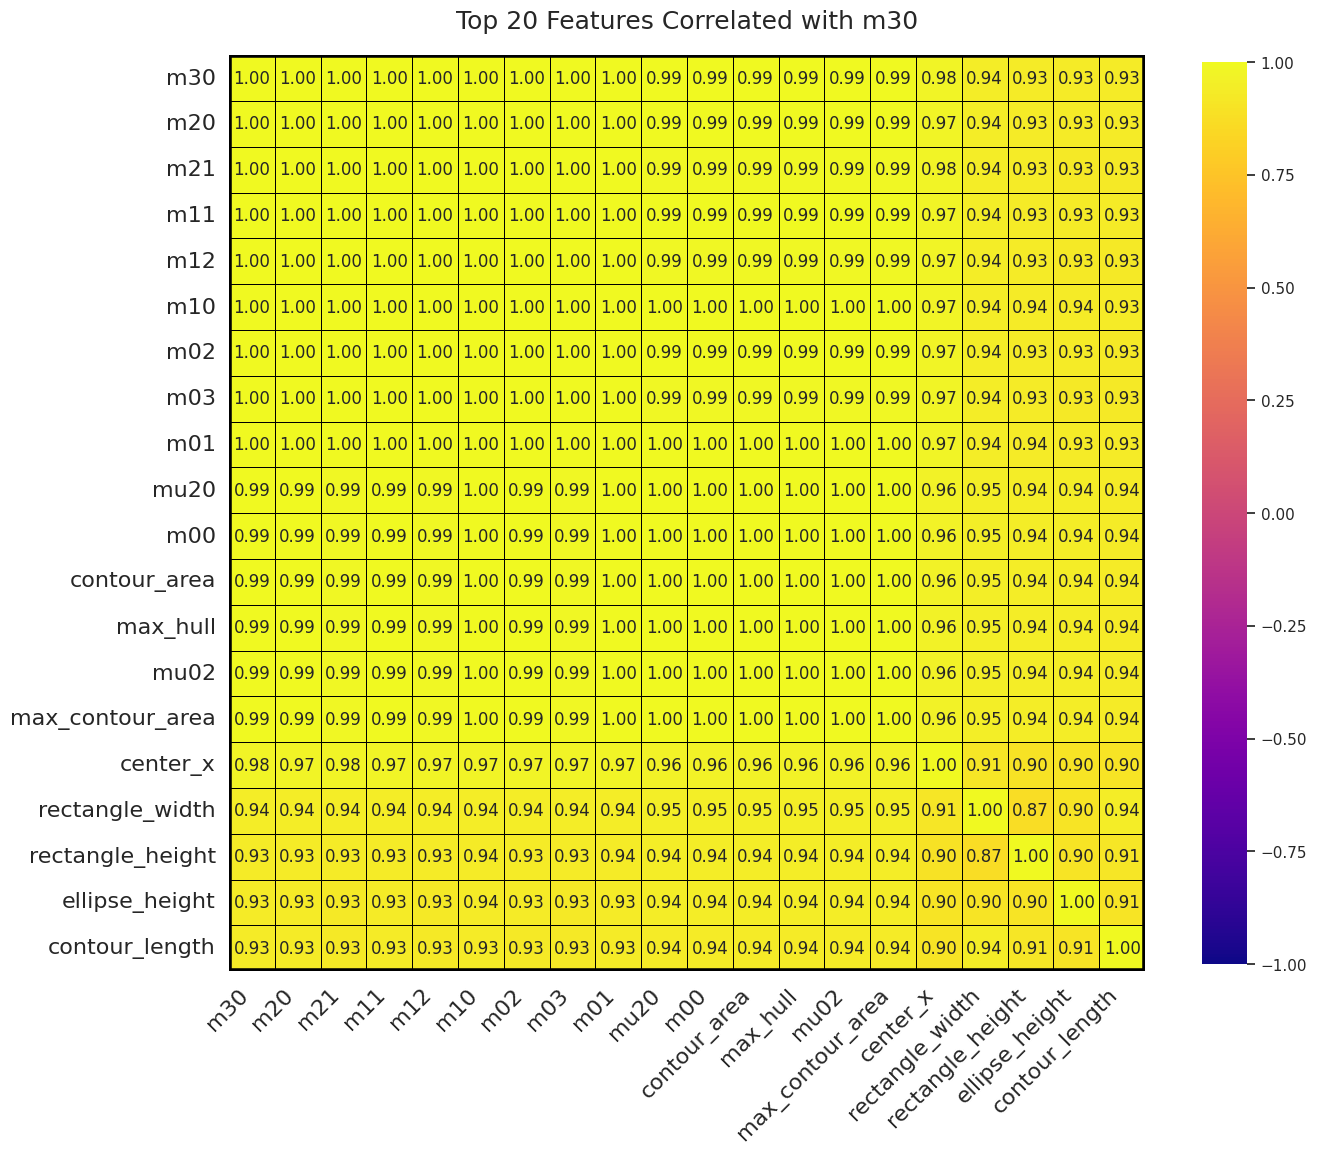

In [72]:
# Example usage:
feature_name = 'm30'
plot_top_correlated_intermodality_features(df_multimodal, feature_name, method='spearman', top_n=20)
save_fig(f"intra-modality correlation_with_{feature_name}.png")

In [93]:
def find_highly_correlated_groups_optimized(dataset, audio_features, vision_features, method='spearman', threshold=0.90):
    """
    Optimized function to find groups of highly correlated features within each modality (audio and vision).
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - audio_features (list): List of audio features in the dataset.
    - vision_features (list): List of vision features in the dataset.
    - method (str): The correlation method, default is 'spearman'.
    - threshold (float): The correlation threshold for considering features as highly correlated.
    
    Returns:
    - List of groups of highly correlated features.
    """
    correlated_groups = []
    processed_features = set()
    
    # Pre-compute the correlation matrices for audio and vision features
    audio_corr_matrix = dataset[audio_features].corr(method=method).abs()
    vision_corr_matrix = dataset[vision_features].corr(method=method).abs()

    for modality, features, corr_matrix in [("audio", audio_features, audio_corr_matrix), 
                                            ("vision", vision_features, vision_corr_matrix)]:
        
        for feature in features:
            if feature in processed_features:
                continue

            # Compute correlations with the given feature using the pre-computed correlation matrix
            correlations_with_feature = corr_matrix[feature]
            
            # Find features that are highly correlated with the given feature
            high_correlation_features = correlations_with_feature[correlations_with_feature > threshold].index.tolist()
            
            # If we find a group of highly correlated features, add them to the list and mark them as processed
            if len(high_correlation_features) > 1:
                correlated_groups.append(high_correlation_features)
                processed_features.update(high_correlation_features)
    
    return correlated_groups

# # Find groups of highly correlated features using the optimized function
# correlated_feature_groups_optimized = find_highly_correlated_groups_optimized(df_multimodal, audio_features, vision_features)

# # Print and plot the first representative feature from each group
# for group in correlated_feature_groups_optimized:
#     print(f"Correlated group: {group}")
#     plot_top_correlated_intermodality_features(df_multimodal, group[0], method='spearman', top_n=15)

In [94]:
from collections import defaultdict

def merge_overlapping_groups(groups):
    """
    Merge overlapping groups of features into unified groups.
    
    Args:
    - groups (list of list): List of feature groups to be merged.
    
    Returns:
    - List of merged feature groups.
    """
    # Initialize the mapping from feature to groups it belongs to
    feature_to_groups = defaultdict(set)
    
    # Populate the feature_to_groups mapping
    for i, group in enumerate(groups):
        for feature in group:
            feature_to_groups[feature].add(i)
    
    # Initialize the list of merged groups
    merged_groups = []
    
    # Initialize the set of processed group indices
    processed_groups = set()
    
    # Loop over each group and merge it with any overlapping groups
    for i, group in enumerate(groups):
        if i in processed_groups:
            continue
        
        # Initialize the merged group as the current group
        merged_group = set(group)
        
        # Initialize the set of groups to be processed
        groups_to_process = {i}
        
        # Merge all overlapping groups
        while groups_to_process:
            current_group_index = groups_to_process.pop()
            current_group = groups[current_group_index]
            
            # Mark the current group as processed
            processed_groups.add(current_group_index)
            
            # Update the merged group
            merged_group.update(current_group)
            
            # Add any unprocessed overlapping groups to groups_to_process
            for feature in current_group:
                overlapping_groups = feature_to_groups[feature] - processed_groups
                groups_to_process.update(overlapping_groups)
        
        # Add the merged group to the list of merged groups
        merged_groups.append(list(merged_group))
    
    return merged_groups

In [95]:
# Find groups of highly correlated features using the optimized function
correlated_feature_groups_optimized = find_highly_correlated_groups_optimized(df_multimodal, audio_features, vision_features)

# Merge the overlapping correlated feature groups
merged_correlated_feature_groups = merge_overlapping_groups(correlated_feature_groups_optimized)

# Print the merged correlated feature groups
merged_correlated_feature_groups

[['spectral_decrease_mean',
  'spectral_energy_mean',
  'spectral_decrease_std',
  'rms_energy',
  'amplitude_envelope_mean',
  'spectral_energy_std',
  'spectral_flux_mean',
  'amplitude_envelope_std'],
 ['zero_crossing_rate',
  'spectral_energy_band_ratio_mean',
  'spectral_rolloff_mean',
  'spectral_skewness_mean'],
 ['spectral_valley_2_mean', 'spectral_valley_1_mean'],
 ['spectral_valley_3_mean', 'mfcc_0_mean'],
 ['spectral_strong_peak_std', 'spectral_strong_peak_mean'],
 ['nu20',
  'm11',
  'max_hull',
  'm20',
  'ellipse_height',
  'm00',
  'rectangle_width',
  'm21',
  'contour_length',
  'max_contour_area',
  'center_x',
  'center_y',
  'ellipse_width',
  'm02',
  'rectangle_height',
  'm03',
  'm30',
  'mu02',
  'm12',
  'm10',
  'm01',
  'contour_area',
  'mu20'],
 ['nu11', 'mu11'],
 ['nu30', 'mu30'],
 ['mu21', 'mu03', 'nu03', 'nu21'],
 ['mu12', 'nu12']]


 Correlated group: ['spectral_energy_mean', 'rms_energy', 'amplitude_envelope_mean', 'spectral_energy_std', 'spectral_flux_mean'] 

Top 15 features correlated with spectral_energy_mean (using spearman correlation):
Index(['spectral_energy_mean', 'rms_energy', 'spectral_energy_std',
       'spectral_flux_mean', 'amplitude_envelope_mean',
       'amplitude_envelope_std', 'spectral_decrease_mean',
       'spectral_decrease_std', 'spectral_flux_std', 'mfcc_0_mean',
       'spectral_valley_2_mean', 'spectral_crest_factor_mean',
       'spectral_crest_factor_std', 'spectral_valley_0_mean',
       'spectral_valley_1_mean'],
      dtype='object')
Saving figure intra-modality correlation_with_spectral_energy_mean_spearman.png

 Correlated group: ['spectral_strong_peak_std', 'spectral_strong_peak_mean'] 

Top 15 features correlated with spectral_strong_peak_std (using spearman correlation):
Index(['spectral_strong_peak_std', 'spectral_strong_peak_mean',
       'spectral_crest_factor_mean', 'spe

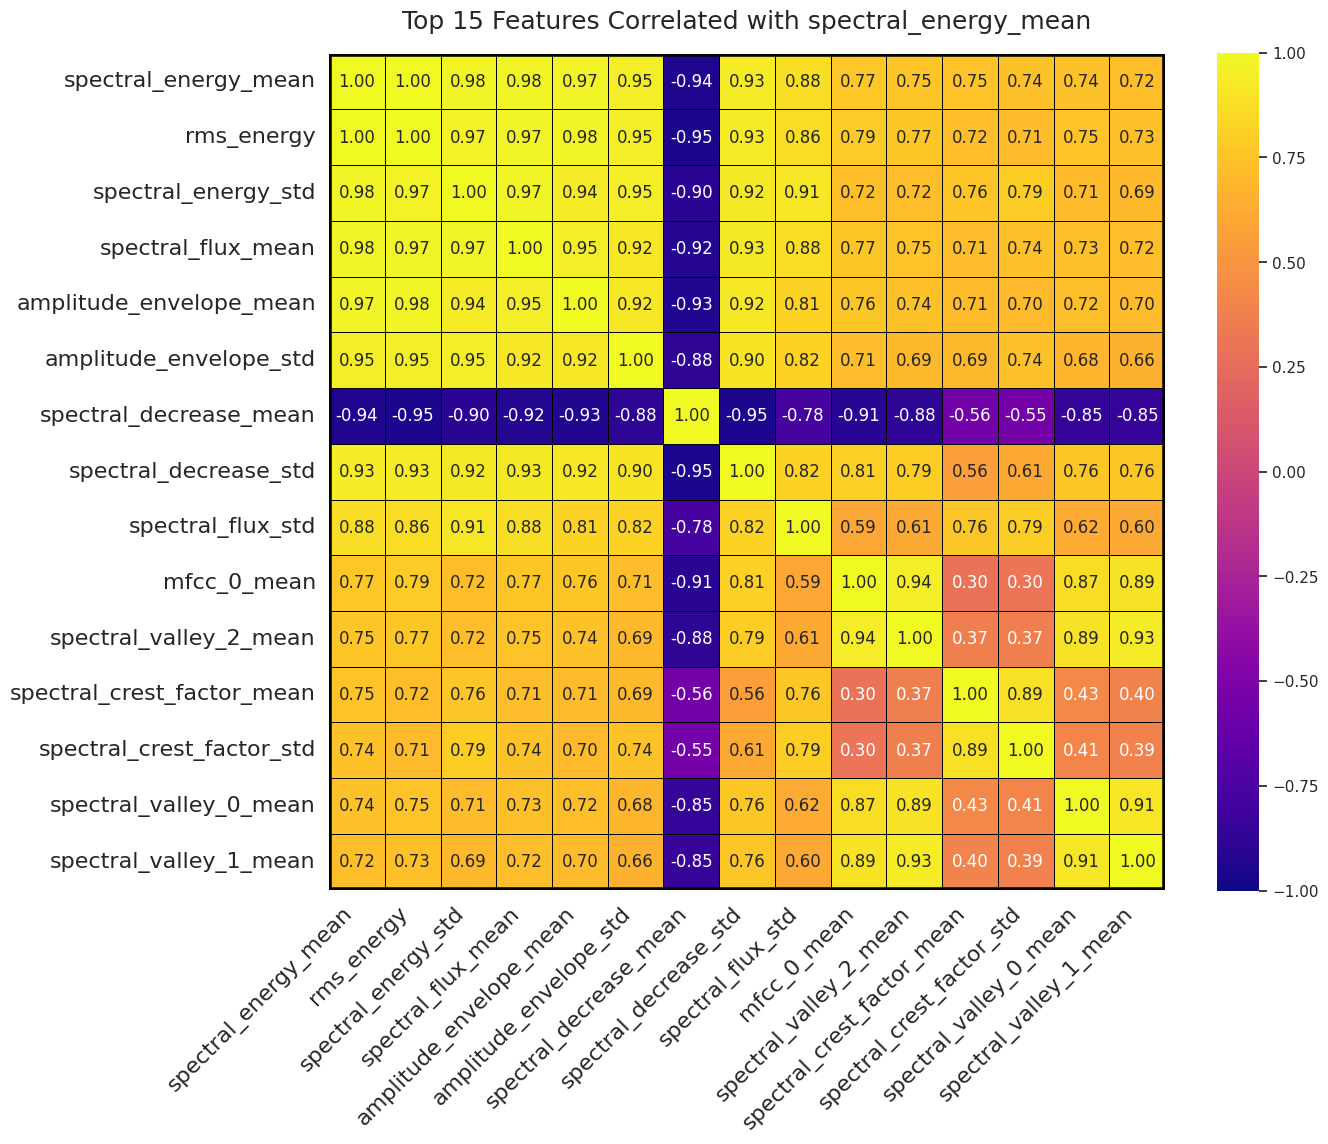

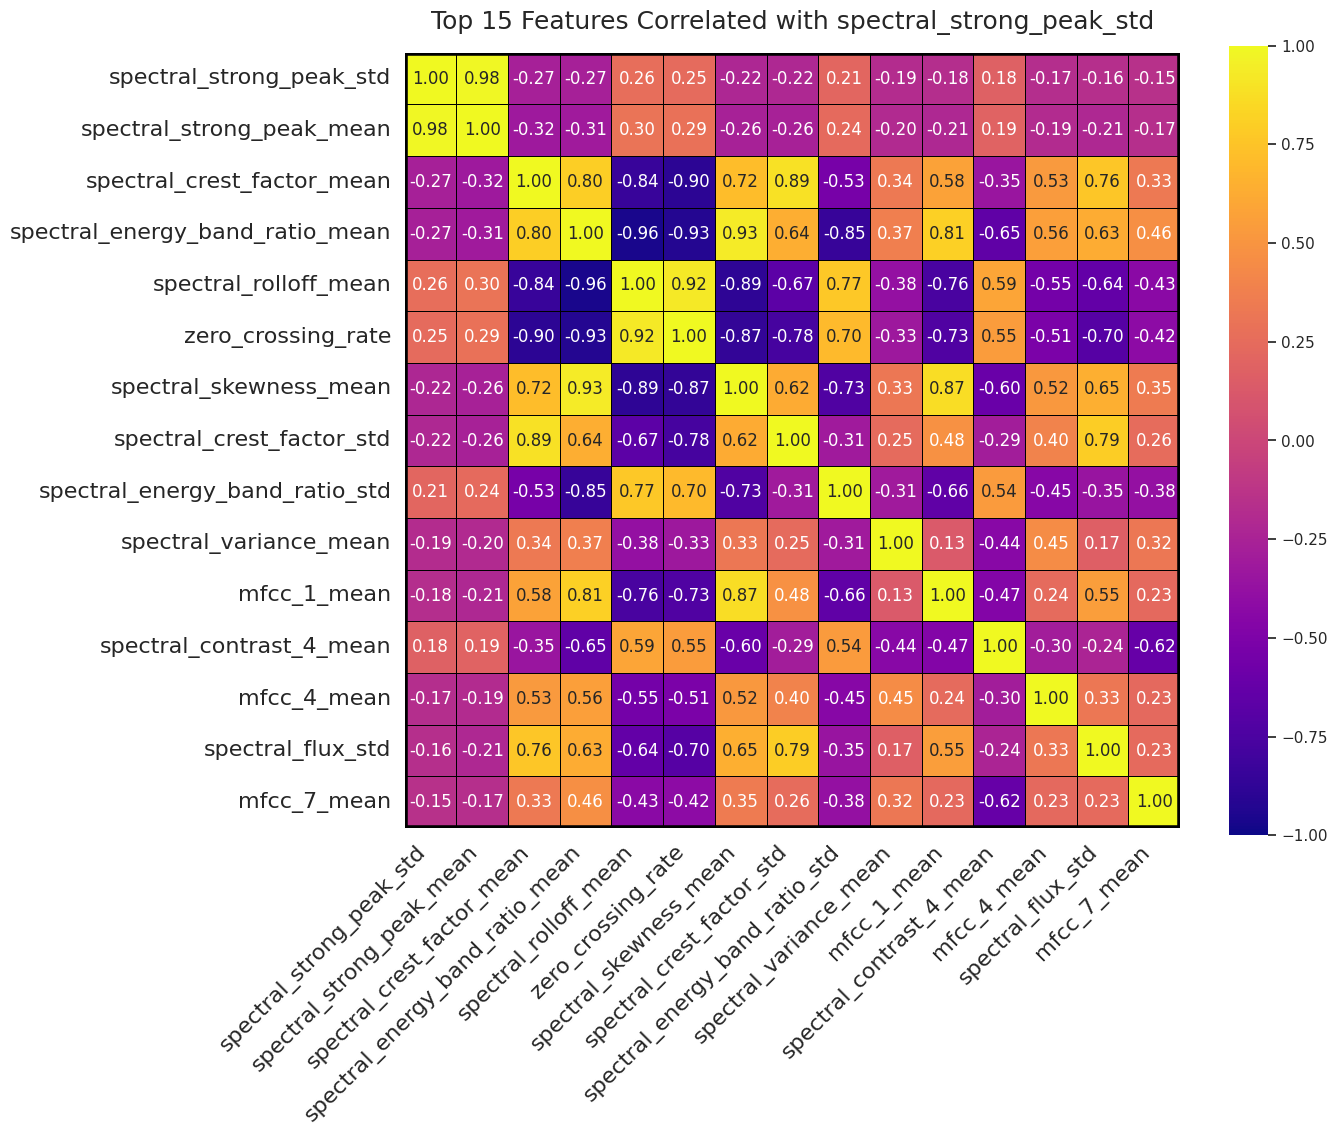

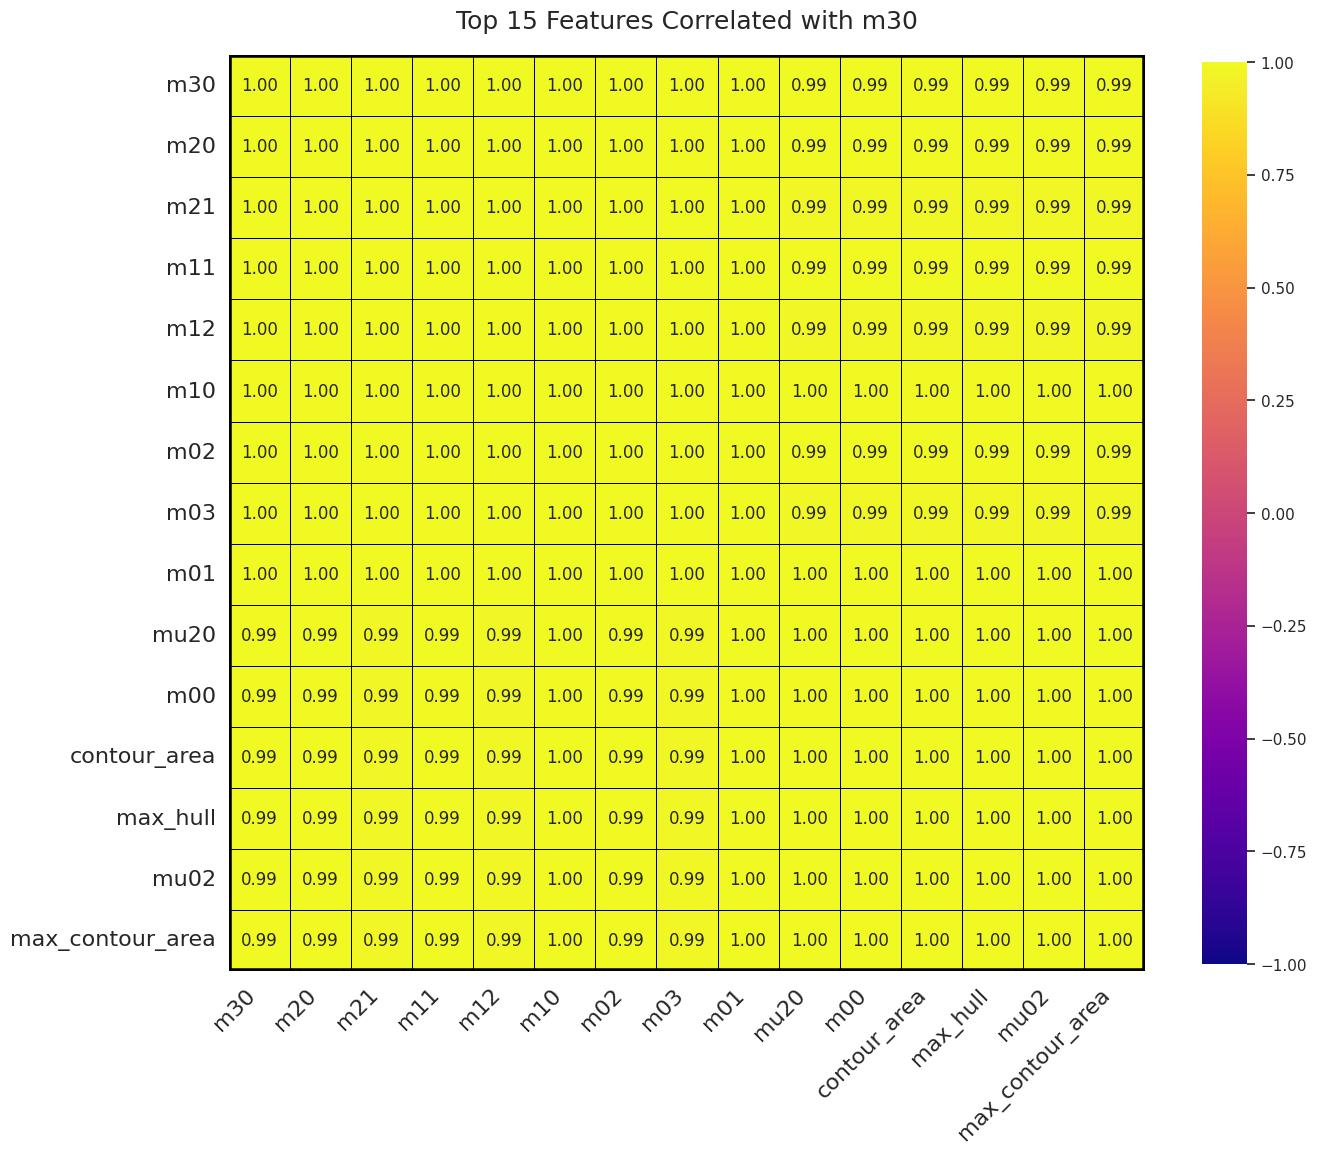

In [70]:
# Print and plot the first representative feature from each group
for group in merged_correlated_feature_groups:
    print(f"\n Correlated group: {group} \n")
    plot_top_correlated_intermodality_features(df_multimodal, group[0], method='spearman', top_n=15)

### Conclusion: 

empty feature: `dynamic_complexity,loudness`

__correlation 0.97 result__:
1. ['spectral_flux_mean', 'amplitude_envelope_mean', 'rms_energy', 'spectral_energy_mean', 'spectral_energy_std']
2. ['spectral_strong_peak_std', 'spectral_strong_peak_mean']
3. ['max_contour_area', 'rectangle_width', 'rectangle_height', 'm11', 'm03', 'ellipse_height', 'ellipse_width', 'contour_area', 'm01', 'm21', 'm00', 'm30', 'center_x', 'm12', 'mu20', 'mu02', 'max_hull', 'm20', 'm02', 'contour_length', 'm10']
4. ['mu03', 'nu03']

__correlation 0.9 result__:
1. ['spectral_flux_mean', 'spectral_decrease_mean', 'spectral_decrease_std', 'amplitude_envelope_std', 'amplitude_envelope_mean', 'rms_energy', 'spectral_energy_mean', 'spectral_energy_std']
2. ['spectral_rolloff_mean', 'spectral_skewness_mean', 'spectral_energy_band_ratio_mean', 'zero_crossing_rate']
3. ['spectral_valley_1_mean', 'spectral_valley_2_mean']
4. ['mfcc_0_mean', 'spectral_valley_3_mean']
5. ['spectral_strong_peak_std', 'spectral_strong_peak_mean']
6. ['max_contour_area', 'rectangle_width', 'rectangle_height', 'nu20', 'm11', 'm03', 'ellipse_height', 'ellipse_width', 'center_y', 'contour_area', 'm01', 'm21', 'm00', 'm30', 'center_x', 'm12', 'mu20', 'mu02', 'max_hull', 'm20', 'm02', 'contour_length', 'm10']
7. ['mu11', 'nu11']
8. ['mu30', 'nu30']
9. ['mu03', 'nu03', 'nu21', 'mu21']
10. ['nu12', 'mu12']

In [136]:
### --------------for 0.97 set-------------
redundant_visual_features = ['rectangle_width', 'rectangle_height', 'm11', 'm03', 'ellipse_height', 
                             'ellipse_width', 'm01', 'm21', 'm00', 'm30', 'center_x', 'm12', 'mu20', 
                             'mu02', 'max_hull', 'm20', 'm02', 'contour_length', 'm10']
redundant_audio_features = ['amplitude_envelope_mean', 'rms_energy', 'spectral_energy_mean', 
                            'spectral_energy_std','dynamic_complexity','loudness']

# redundant_visual_features = ['m30', 'm21', 'm12', 'm03', 'm20', 'm11', 'm02', 'm10', 'm01', 'm00', 
#                              'max_hull', 'contour_area', 'mu20', 'mu02']
# redundant_audio_features = ['amplitude_envelope_mean', 'spectral_energy_mean', 
#                             'spectral_flux_mean', 'spectral_energy_std']

# Remove these redundant columns from the df_multimodal DataFrame
df_multimodal_dropped = df_multimodal.drop(columns=redundant_visual_features + redundant_audio_features)

# Show some information about the updated DataFrame to confirm that the columns have been dropped
df_multimodal_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32946 entries, 0 to 48465
Columns: 109 entries, sample index to Speed
dtypes: category(4), float32(51), float64(52), int64(2)
memory usage: 26.5 MB


In [137]:
### --------------for 0.90 set-------------
# Choose a representative feature from each group to keep, and list the rest as redundant
redundant_visual_features_09 = ['rectangle_width', 'rectangle_height', 'nu20', 'm11', 'm03', 'ellipse_height', 
                                'ellipse_width', 'center_y', 'contour_area', 'm01', 'm21', 'm00', 'm30', 'center_x', 
                                'm12', 'mu20', 'mu02', 'max_hull', 'm20', 'm02', 'contour_length', 'm10', 'mu11', 
                                'nu11', 'mu30', 'nu30', 'mu03', 'nu21', 'mu21', 'nu12', 'mu12']
redundant_audio_features_09 = ['spectral_decrease_mean', 'spectral_decrease_std', 'amplitude_envelope_std', 
                               'amplitude_envelope_mean', 'rms_energy', 'spectral_energy_mean', 'spectral_energy_std', 
                               'spectral_skewness_mean', 'spectral_energy_band_ratio_mean', 'zero_crossing_rate', 
                               'spectral_valley_1_mean', 'mfcc_0_mean', 'spectral_strong_peak_std','dynamic_complexity','loudness']

# Remove these redundant columns from the df_multimodal DataFrame
df_multimodal_dropped_09 = df_multimodal.drop(columns=redundant_visual_features_09 + redundant_audio_features_09)

# Show some information about the updated DataFrame to confirm that the columns have been dropped
df_multimodal_dropped_09.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32946 entries, 0 to 48465
Data columns (total 88 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   sample index                    32946 non-null  int64   
 1   Time_Stamps                     32946 non-null  float64 
 2   audio_file_name                 32946 non-null  category
 3   image_file_name                 32946 non-null  category
 4   class_name                      32946 non-null  category
 5   class_name_v2                   32946 non-null  category
 6   Layer number                    14568 non-null  float64 
 7   Sample number                   32946 non-null  int64   
 8   loudness_vickers                32946 non-null  float64 
 9   spectral_centroid_mean          32946 non-null  float64 
 10  spectral_centroid_std           32946 non-null  float64 
 11  spectral_complexity_mean        32946 non-null  float64 
 12  spectral_complexit

In [97]:
df_multimodal_dropped_09

,sample index,Time_Stamps,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,dynamic_complexity,loudness,...,ellipse_angle,nu02,nu03,X,Y,Z,Vx,Vy,Vz,Speed
0,1,0.00,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,0.0,-100.0,...,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,2,0.04,sample_21_2.wav,sample_21_2.jpg,Defect-free,Defect-free,1.0,21,0.0,-100.0,...,0.000000,0.062337,0.000000,0.000,-0.000,0.001,-0.074,-0.074,0.000,0.105
2,3,0.08,sample_21_3.wav,sample_21_3.jpg,Defect-free,Defect-free,1.0,21,0.0,-100.0,...,0.000000,0.062337,0.000000,-0.010,0.015,-0.007,-0.051,0.026,-0.051,0.077
3,4,0.12,sample_21_4.wav,sample_21_4.jpg,Defect-free,Defect-free,1.0,21,0.0,-100.0,...,69.979729,0.062216,0.000891,-0.007,0.016,0.010,0.173,-0.222,2.520,2.536
4,5,0.16,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,0.0,-100.0,...,14.217007,0.065910,0.001388,-0.111,0.123,-0.057,-1.864,1.662,-2.468,3.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48461,10982,439.24,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,Laser-off,NaN,26,0.0,-100.0,...,0.000000,0.000000,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48462,10983,439.28,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,Laser-off,NaN,26,0.0,-100.0,...,0.000000,0.000000,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48463,10984,439.32,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,Laser-off,NaN,26,0.0,-100.0,...,0.000000,0.000000,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48464,10985,439.36,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,Laser-off,NaN,26,0.0,-100.0,...,0.000000,0.000000,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080


### Intra-modality correlation (after dropping)

In [116]:
# Update the function to plot top correlated intra-modality features after dropping redundant features
def plot_top_correlated_intra_modality_features_updated(dataset, feature_name, method='spearman', top_n=10):
    """
    Function to plot the top N correlated features with a given feature from the dataset.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - feature_name (str): The feature with which correlations are to be found.
    - method (str): The correlation method, default is 'spearman'.
    - top_n (int): Number of top correlated features to be plotted, default is 10.
    """
    
    # Determine the remaining features after dropping
    remaining_audio_features = list(set(audio_features) - set(redundant_audio_features))
    remaining_vision_features = list(set(vision_features) - set(redundant_visual_features))
    
    # Ensure the provided feature_name exists in the dataset
    if feature_name not in dataset.columns:
        print(f"Feature '{feature_name}' not found in the dataset!")
        return

    # Determine if the given feature is from audio or vision
    if feature_name in remaining_audio_features:
        relevant_features = remaining_audio_features
    elif feature_name in remaining_vision_features:
        relevant_features = remaining_vision_features
    else:
        print(f"Feature '{feature_name}' is not recognized as audio or vision feature!")
        return

    # Compute correlations with the given feature using the specified correlation method
    correlations_with_feature = dataset[relevant_features].corr(method=method)[feature_name]
    
    # Get top N absolute correlations (including the feature_name)
    top_correlations = correlations_with_feature.abs().nlargest(top_n).index
    top_correlation_values = dataset[top_correlations].corr(method=method)

    # Print the top N features
    print(f"Top {top_n} features correlated with {feature_name} (using {method} correlation):")
    print (top_correlations)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .7},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k', linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k', linewidth=4)
    ax.axvline(x=0, color='k', linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k', linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {feature_name}", fontsize=18, y=1.02)
    save_fig(f"intra-modality correlation_with_{feature_name}_{method}(after dropping).png")

Top 10 features correlated with spectral_centroid_mean (using spearman correlation):
Index(['spectral_centroid_mean', 'spectral_centroid_std',
       'spectral_crest_factor_mean', 'spectral_crest_factor_std',
       'zero_crossing_rate', 'spectral_flux_mean', 'spectral_flux_std',
       'amplitude_envelope_std', 'spectral_rolloff_mean',
       'spectral_energy_band_ratio_mean'],
      dtype='object')
Saving figure intra-modality correlation_with_spectral_centroid_mean_spearman(after dropping).png


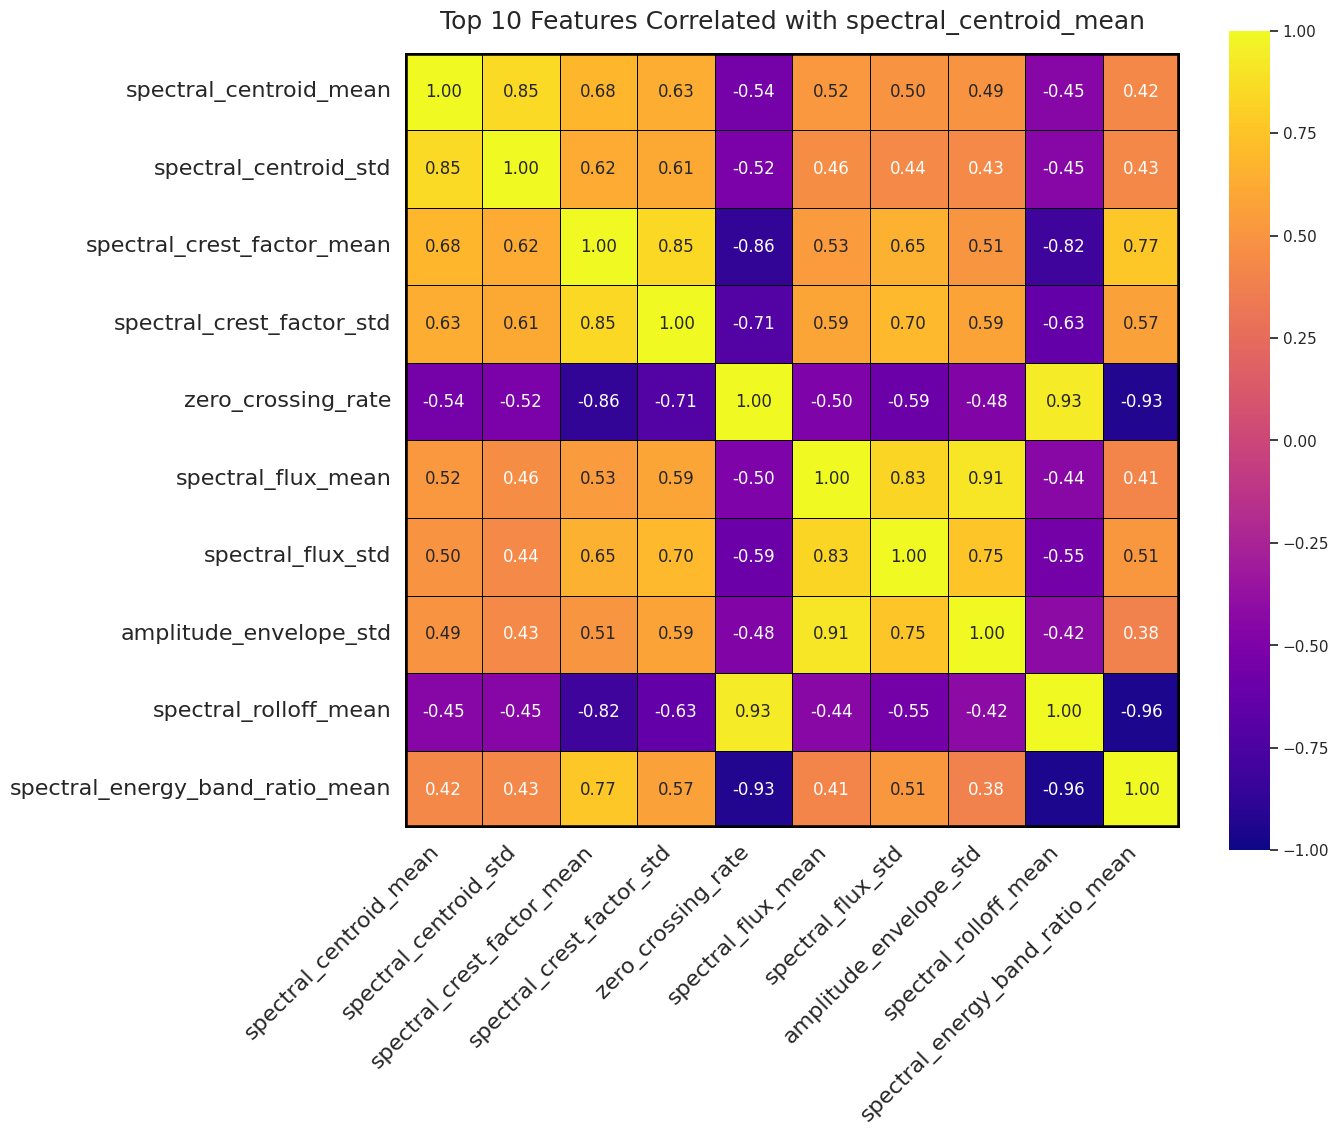

In [117]:
plot_top_correlated_intra_modality_features_updated(df_multimodal_dropped, 'spectral_centroid_mean')

## 2. Cross-modality feature analysis: Find the top N correlated features with a given feature 
- If the given feature is from the audio set, only visual features will be considered for correlation.
- If the given feature is from the vision set, only audio features will be considered for correlation.

    - This is a crucial step, especially for multimodal data. It helps to understand if there's any redundancy between the two modalities. For instance, if a visual feature is highly correlated with an audio feature, it might indicate that they both capture the same event or phenomenon.

    - A correlation of 0.5 is moderate. It suggests that there's some relationship between the audio and visual features, but it's not a perfect linear relationship. This is often a good sign because it indicates that while the two modalities have some overlap in the information they capture, they also provide unique information

Saving figure cross-modality correlation_with_max_contour_area_spearman.png


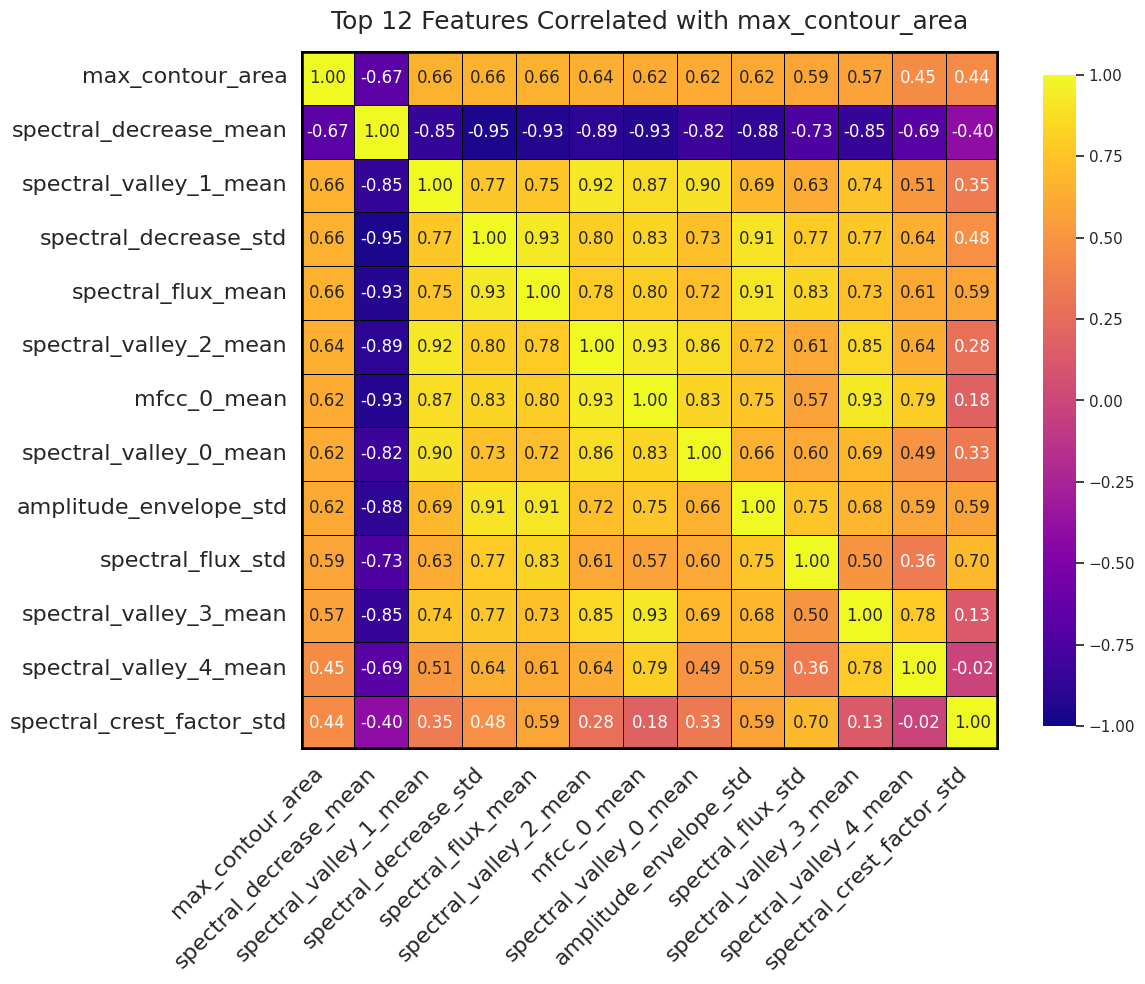

In [120]:
def plot_top_correlated_features(dataset, feature_name, method='spearman', top_n=10):
    """
    Function to plot the top N correlated features with a given feature from the dataset.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - feature_name (str): The feature with which correlations are to be found.
    - method (str): The correlation method, default is 'spearman'.
    - top_n (int): Number of top correlated features to be plotted, default is 10.
    """
    
    
    # Ensure the provided feature_name exists in the dataset
    if feature_name not in dataset.columns:
        print(f"Feature '{feature_name}' not found in the dataset!")
        return

    # Determine if the given feature is from audio or vision
    if feature_name in audio_features:
        relevant_features = list(set(vision_features) - set(redundant_visual_features)) 
    elif feature_name in vision_features:
        relevant_features = list(set(audio_features) - set(redundant_audio_features))
    else:
        print(f"Feature '{feature_name}' is not recognized as audio or vision feature!")
        return


    # Compute correlations with the given feature using the specified correlation method
    correlations = dataset[[feature_name] + relevant_features].corr(method=method)
    correlations_with_feature = correlations[feature_name].drop(feature_name)

    # Get top N absolute correlations
    top_correlations = correlations_with_feature.abs().nlargest(top_n).index
    top_correlation_values = dataset[[feature_name] + list(top_correlations)].corr(method=method)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    
    plt.title(f"Top {top_n} Features Correlated with {feature_name}", fontsize=18, y=1.02)
    save_fig(f"cross-modality correlation_with_{feature_name}_{method}.png")
    plt.show()

# Example usage:
plot_top_correlated_features(df_multimodal_dropped, 'max_contour_area', method='spearman', top_n=12)

### 3. Top Correlated Features for Each Individual Output Category:

- After removing redundant features
- The labels in the column `class_name` are categorical strings. Correlation with categorical strings doesn't make sense in the context of Spearman or Pearson correlation. 
- One way to handle this is to convert each class to a binary format, where 1 indicates the presence of the class and 0 indicates the absence.

By understanding which features are most indicative of each category, you can gain insights into the nature of the data and the categories themselves.
Certain phenomena might be more easily captured by one modality over another.

Saving figure correlation_matrix_Crack_spearman.png


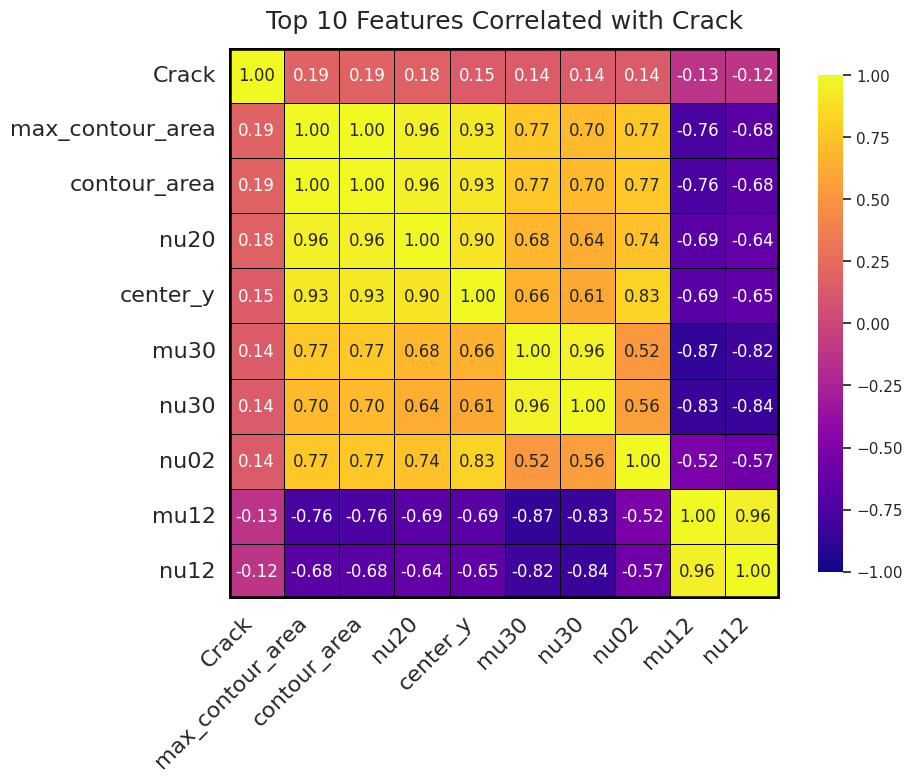

Saving figure correlation_matrix_Defect-free_spearman.png


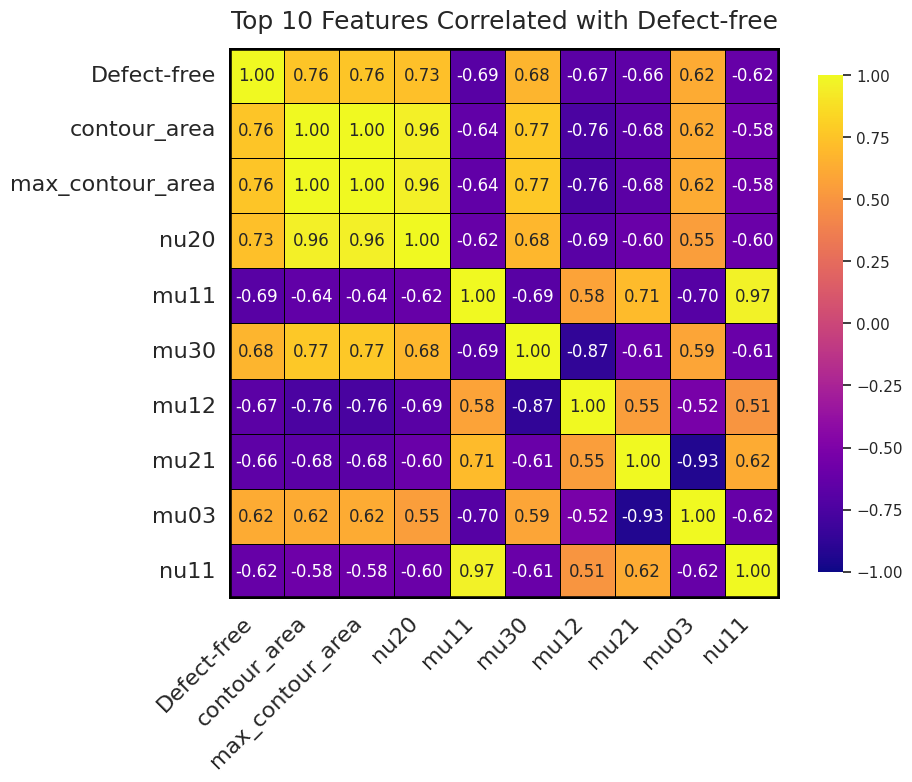

Saving figure correlation_matrix_Keyhole pores_spearman.png


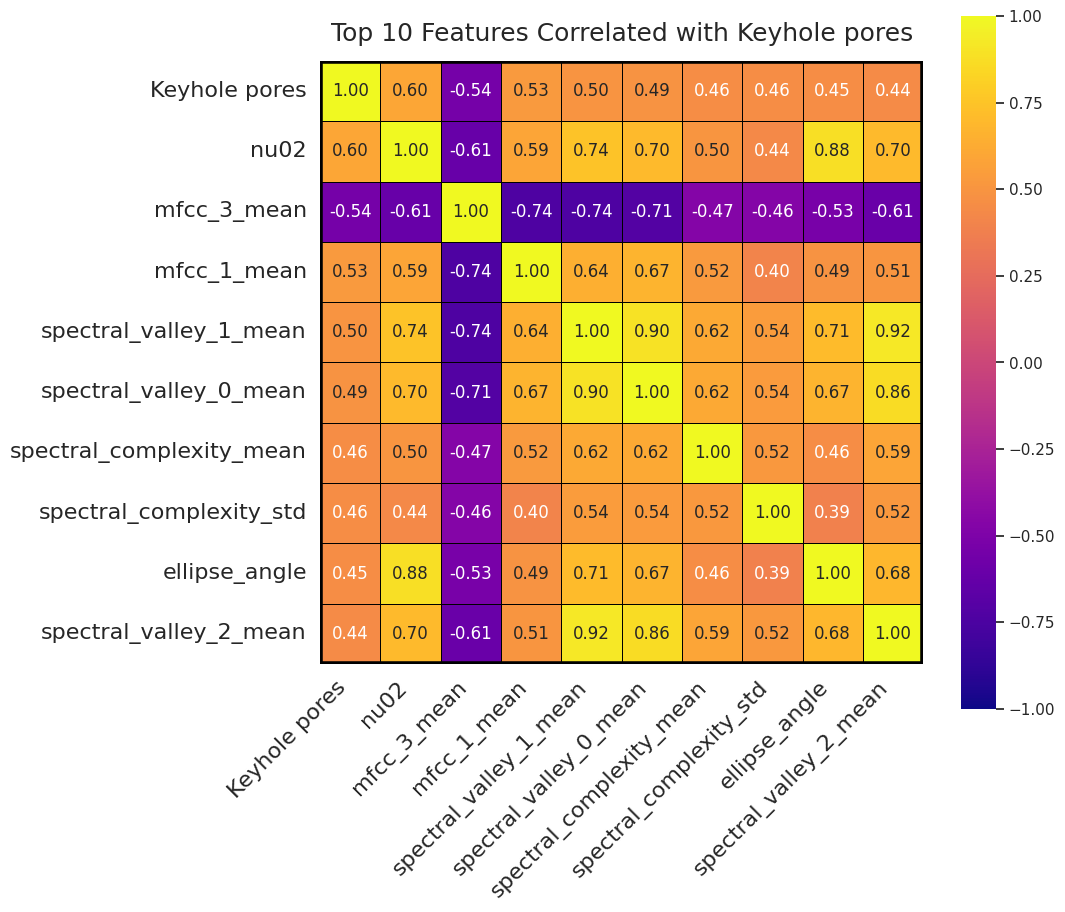

Saving figure correlation_matrix_Laser-off_spearman.png


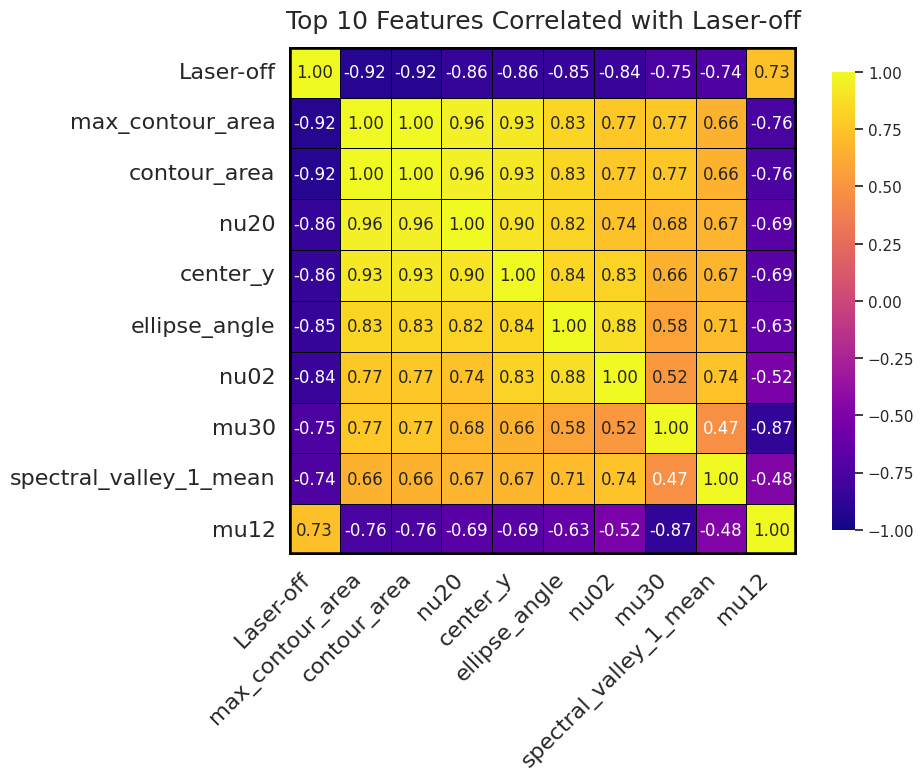

In [121]:
def plot_custom_style_top_correlated_features(dataset, target_column, method='spearman', top_n=10):
    # Convert the target_column to binary format
    dataset_binary = dataset.copy()
    dataset_binary[target_column] = pd.get_dummies(dataset_binary['class_name'])[target_column]

    # Drop non-feature columns
    non_feature_columns = ['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                           'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z']
    dataset_dropped = dataset_binary.drop(columns=non_feature_columns)
    
    # Compute correlations with the target column using Spearman/Pearson correlation
    correlations_with_target = dataset_dropped.corr(method=method)[target_column].drop(target_column)
    
    # Get top N absolute correlations (including the target)
    top_correlations = correlations_with_target.abs().nlargest(top_n - 1).index
    top_correlations = top_correlations.insert(0, target_column)
    top_correlation_values = dataset_dropped[top_correlations].corr(method=method)

    # Adjust figure size for 'Keyhole pores'
    fig_size = (11, 10) if target_column == 'Keyhole pores' else (10, 8)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k', linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k', linewidth=4)
    ax.axvline(x=0, color='k', linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k', linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {target_column}", fontsize=18, y=1.02)
    save_fig(f"correlation_matrix_{target_column}_{method}.png")
    plt.show()

quality_categories = ['Crack', 'Defect-free', 'Keyhole pores', 'Laser-off']

# Loop over each material category to generate the plot
for quality in quality_categories:
    plot_custom_style_top_correlated_features(df_multimodal_dropped, quality, method='spearman', top_n=10)

### 4. Correlation with Output Class

This step is about understanding the overall relationship between features and the target, regardless of the specific categories within the target. It gives a holistic view and can be particularly useful for:
1. Feature selection: If certain features are very weakly correlated with the overall target, they might not be useful predictors.
2. Understanding the general importance of features: While individual category correlations give insights about specific classes, this step gives a broader perspective.
3. Preparing for machine learning models that might treat the problem as multi-class without focusing on individual categories.

Saving figure Top 15 Features Correlated with class_name


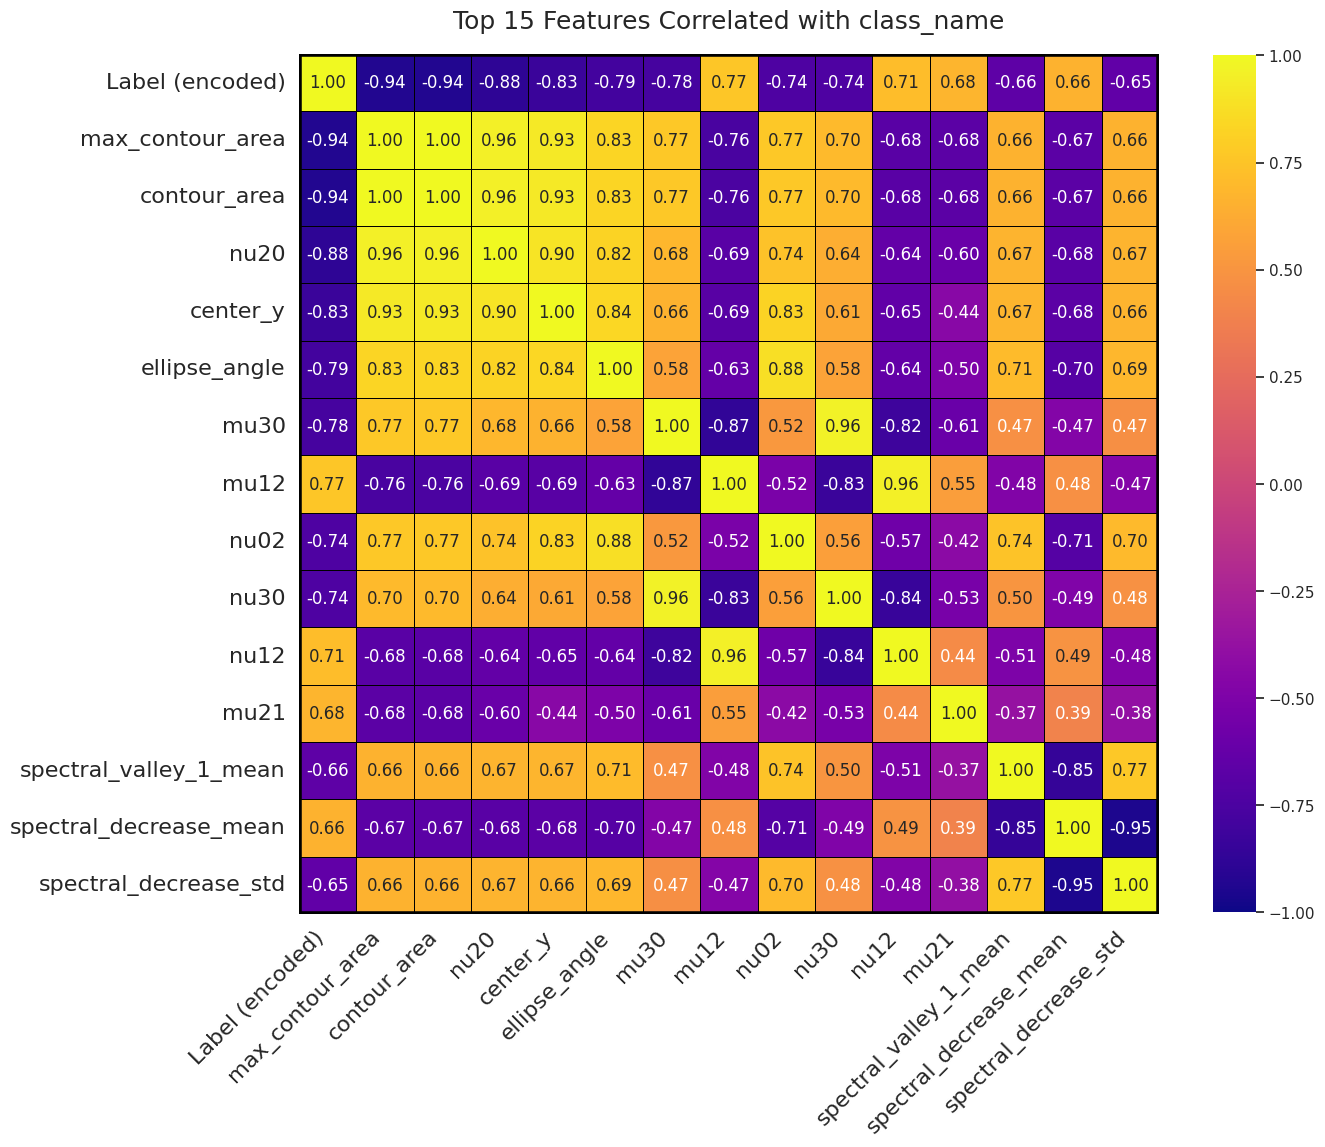

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def plot_correlation_with_output_class(dataset, target_column='class_name', method='spearman', top_n=10):
    
    # Remove non-feature columns
    non_feature_columns = ['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                           'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z']
    dataset_features = dataset.drop(columns=non_feature_columns)
    
    # Convert categorical class labels into numeric labels
    le = LabelEncoder()
    dataset_features['Label (encoded)'] = le.fit_transform(dataset[target_column])
    
    # Compute correlations with the target class
    correlations = dataset_features.corr(method=method)
    correlations_with_class = correlations['Label (encoded)']
    
    # Get top N absolute correlations (including the target class)
    top_correlations = correlations_with_class.abs().nlargest(top_n).index
    top_correlation_values = dataset_features[top_correlations].corr(method=method)
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {target_column}", fontsize=18, y=1.02)
    save_fig(f"Top {top_n} Features Correlated with {target_column}")
    # plt.show()

# Usage
plot_correlation_with_output_class(df_multimodal_dropped, target_column='class_name', method='spearman', top_n=15)

### Feature importance ranking by RF

contour_area              0.160203
max_contour_area          0.076834
nu02                      0.073672
center_y                  0.052968
mu12                      0.051499
mu30                      0.050836
nu20                      0.048281
ellipse_angle             0.045766
mfcc_3_mean               0.041598
Time_Stamps               0.039651
spectral_valley_1_mean    0.035068
nu12                      0.034036
nu30                      0.025718
mfcc_1_mean               0.024590
mu21                      0.023570
nu03                      0.018998
mu11                      0.017871
mu03                      0.016568
spectral_valley_2_mean    0.008715
spectral_flux_mean        0.007973
dtype: float64
Saving figure RF feature importance ranking (20)


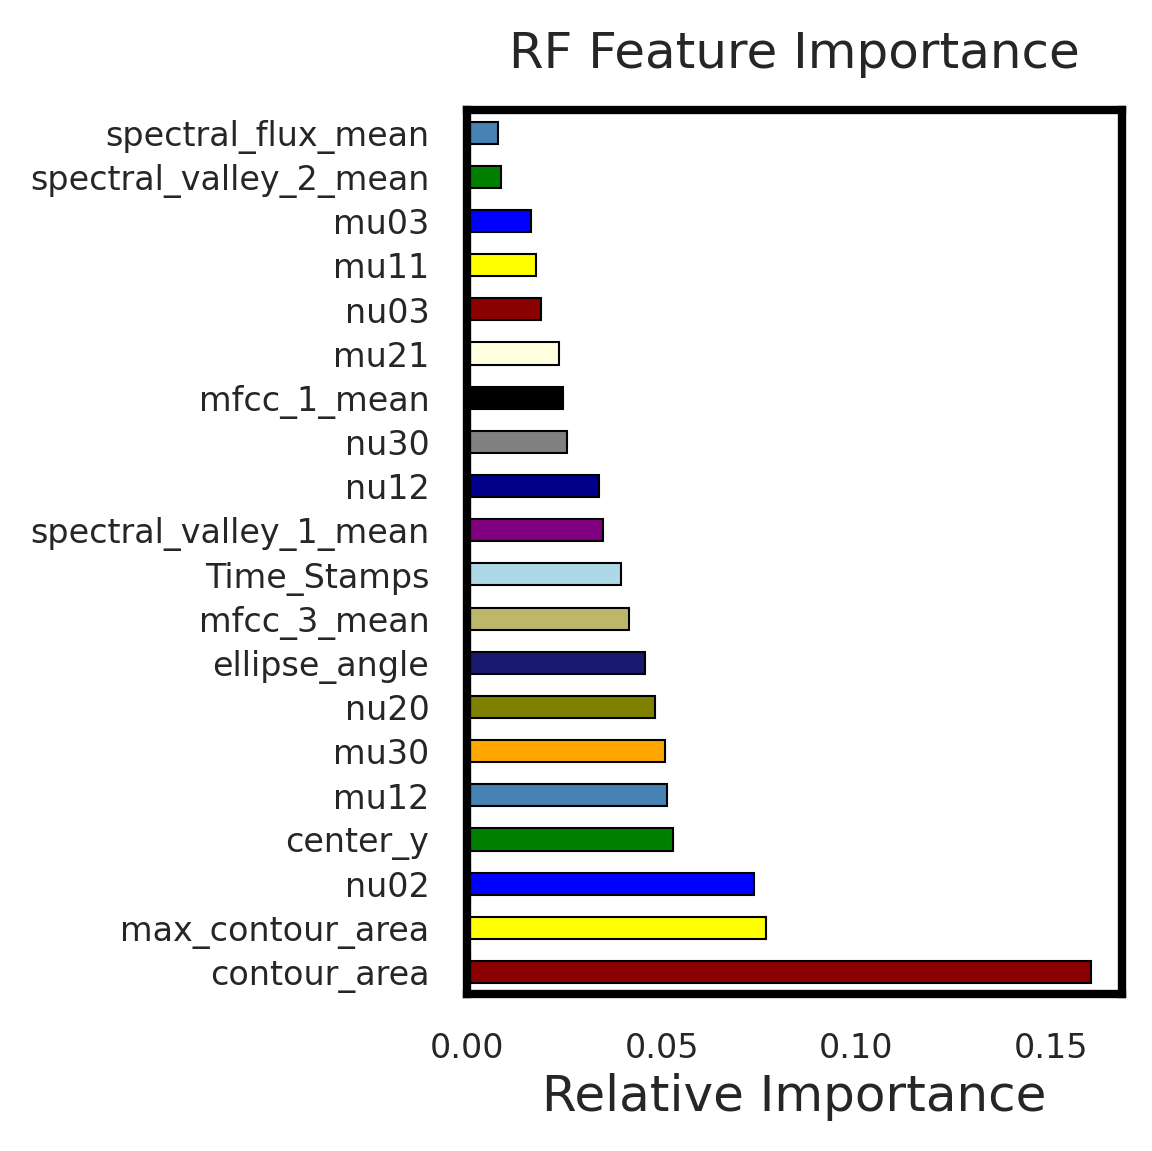

In [129]:
# Define the dataset and target variable
y = df_multimodal_dropped['class_name']

non_feature_columns = ['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                        'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z', 'Vx', 'Vy' ,'Vz', 'Speed']
dataset_dropped = df_multimodal_dropped.drop(columns=non_feature_columns)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)
model.fit(dataset_dropped, y)

# Extract feature importances
feat_importances = pd.Series(model.feature_importances_, index=dataset_dropped.columns)


# Plotting the feature importances
fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.gca()
widths = 2
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)
    
color = ['darkred','yellow', 'blue','green', 'steelblue','orange', 'olive', 'midnightblue', 'darkkhaki', 
         "lightblue", "purple", "darkblue", "gray", "black", "lightyellow"]


top_n = 20
feat_importances.nlargest(top_n).plot(kind='barh', color=color, edgecolor='k', linewidth=0.5)
plt.title("RF Feature Importance", fontsize=12, y=1.02)
plt.xlabel('Relative Importance', fontsize=12, labelpad=2)
plt.tick_params(axis='both', labelsize=8, pad=3)

# Displaying the top 15 feature importances
top_feature_importances = feat_importances.nlargest(top_n)
print (top_feature_importances)
save_fig(f"RF feature importance ranking ({top_n})")

### 5. ANOVA (Analysis of Variance) analysis

Explanation of F-value and P-value in ANOVA

- `F-value`: In the context of ANOVA (Analysis of Variance), the F-value represents the ratio of the variance between different groups to the variance within the groups. A __higher F-value__ suggests that the feature is important in distinguishing between the different classes in the target variable.

- `Null Hypothesis in ANOVA`: The null hypothesis in ANOVA is that all classes of the target variable have the same mean for the feature being tested. In other words, the feature doesn't help in distinguishing between different classes.

- `P-value`: It's a measure to support or refute this null hypothesis. The P-value tells you the probability of observing your data, or something more extreme, if the null hypothesis is true.
    - The P-value gives the probability of obtaining an F-value at least as extreme as the one computed, assuming that the null hypothesis is true (i.e., that there's no effect or difference). A __lower P-value (< 0.05 is often considered)__ indicates that you can reject the null hypothesis, making the feature important.

    - `Low P-value` (typically < 0.05): It means that it's very unlikely to observe such data if the null hypothesis is true. This gives you enough evidence to "reject the null hypothesis" and conclude that the feature is significant in distinguishing between different classes.

    - `High P-value`: It means that what you've observed is likely under the null hypothesis, so you don't have enough evidence to reject it. This would mean that the feature is not very useful in distinguishing between different classes.
    
- For  feature importance, the bar plot represents the top N features sorted by their F-values in the first graph and by their Mutual Information scores in the second graph.  The features at the top are considered to be more important in predicting the target variable.

In [138]:
# Importing required libraries
from sklearn.feature_selection import f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def anova_feature_importance(dataset, X, y, top_n=10):
    """
    Compute and plot the ANOVA F-values and P-values for feature importance.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - X (array): Feature matrix.
    - y (array): Target array.
    - top_n (int): Number of top features to display.
    
    Returns:
    - sorted_df (pd.DataFrame): Sorted DataFrame containing F-values and P-values.
    """
    # Compute ANOVA F-values and P-values
    f_values, p_values = f_classif(X, y)
    
    # Create DataFrame for ANOVA feature importance
    anova_importance_df = pd.DataFrame({
        'Feature': dataset.columns,
        'F_value': f_values,
        'p_value': p_values
    })

    # Sort the features by F_value in descending order
    sorted_df = anova_importance_df.sort_values(by='F_value', ascending=False)
    
    # Get the top N features
    top_features = sorted_df.head(top_n)
    
    # Plotting F-values
    plt.figure(figsize=(12, 10))
    plt.barh(top_features['Feature'], top_features['F_value'], color='skyblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('F-value', fontsize=18, labelpad=15)
    plt.ylabel('Feature', fontsize=18, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'Top {top_n} Features using ANOVA F-value', pad=15, fontsize=20)
    save_fig(f'Top {top_n} Features using ANOVA F-value')
    # plt.show()
    
    # Plotting P-values
    # plt.figure(figsize=(12, 10))
    # plt.barh(top_features['Feature'], top_features['p_value'], color='orange', edgecolor='black', linewidth=0.5)
    # plt.xlabel('P-value', fontsize=18, labelpad=15)
    # plt.ylabel('Feature', fontsize=18, labelpad=15)
    # plt.xticks(fontsize=14)
    # plt.yticks(fontsize=14)
    # plt.title(f'Top {top_n} Features using ANOVA P-value', pad=15, fontsize=20)
    # plt.show()
    
    return sorted_df

Saving figure Top 25 Features using ANOVA F-value


,Feature,F_value,p_value
86,nu20,34362.954214,0.000000e+00
93,center_y,19383.456350,0.000000e+00
88,nu02,17272.690365,0.000000e+00
22,spectral_valley_1_mean,13194.134215,0.000000e+00
58,mfcc_3_mean,11230.624158,0.000000e+00
...,...,...,...
69,mfcc_8_std,32.810638,3.629678e-21
65,mfcc_6_std,24.599525,6.823760e-16
9,spectral_contrast_0_std,21.714134,4.824445e-14
77,mfcc_12_std,21.652881,5.280523e-14


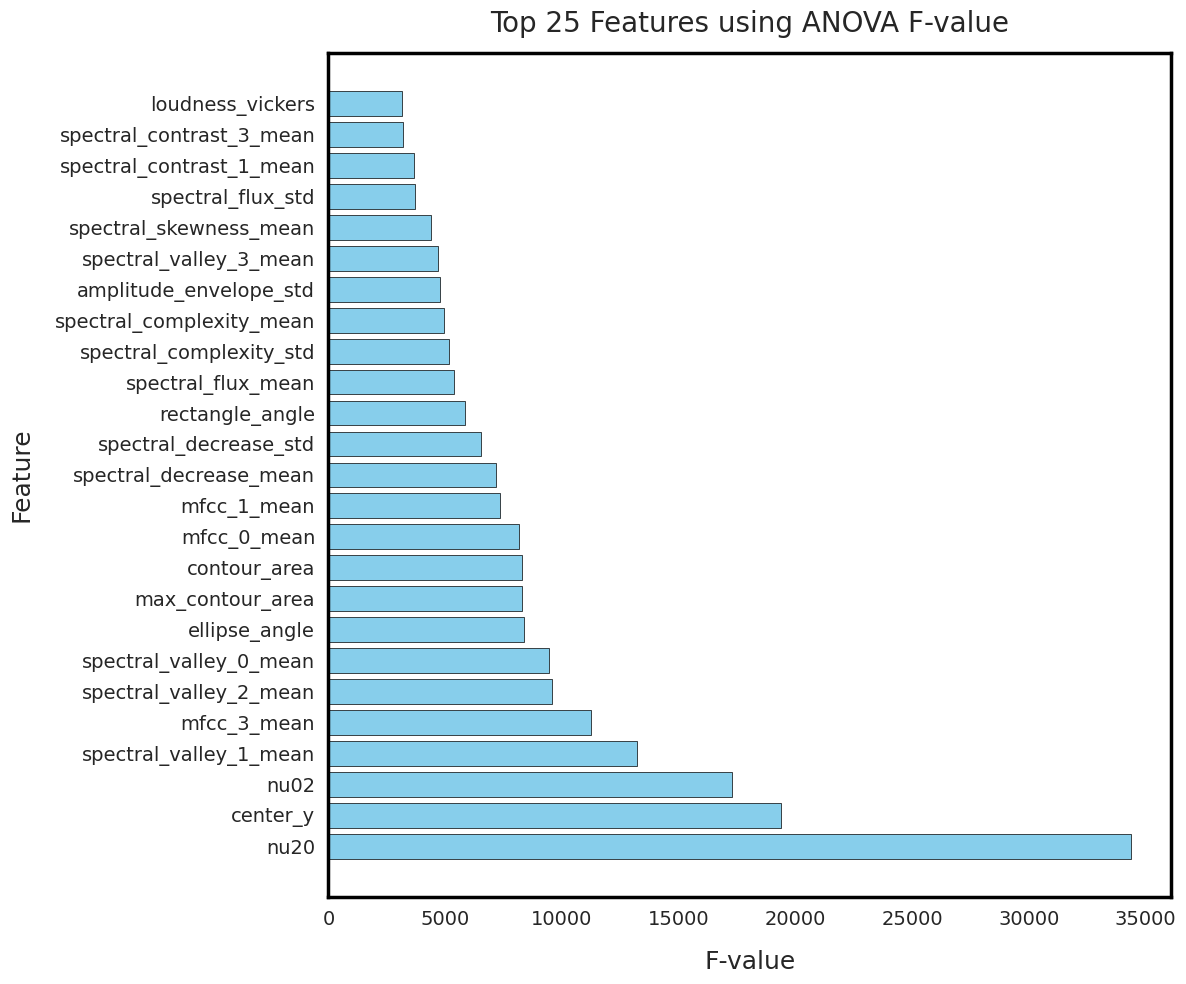

In [139]:
# Prepare data
non_feature_columns = ['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                        'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z', 'Vx', 'Vy' ,'Vz', 'Speed']

dataset = df_multimodal_dropped.drop(columns=non_feature_columns)
X = dataset.to_numpy()
y = df_multimodal['class_name'].to_numpy()


# Run the function 
sorted_df = anova_feature_importance(dataset, X, y, top_n=25)
sorted_df

### Feature selection based on ANOVA
- A higher F-value generally suggests that the feature is __more important or discriminative__ for classification. It indicates that the means of the different classes are more separated, which usually implies the feature is good for classification.

- A lower p-value means that the feature is __statistically significant__ in explaining the dependent variable. A  p-value less than a threshold (commonly 0.05) is typically considered evidence that the feature is important.

- However, a higher F-value does not necessarily mean a lower p-value, although they are often inversely related in many cases. The p-value is calculated based on the  F-value and the degrees of freedom in the model. It's possible for a feature to have a high  F-value but still not be statistically significant if, for example, the degrees of freedom are low.

In [140]:
def filter_anova_features(sorted_df, p_value_threshold=0.05, f_value_threshold=None):
    """
    Filter features based on ANOVA F-value and p-value.
    
    Args:
    - sorted_df (pd.DataFrame): The input DataFrame containing 'Feature', 'F_value', and 'p_value' columns.
    - p_value_threshold (float): The p-value threshold for feature elimination. Default is 0.05.
    - f_value_threshold (float): The F-value threshold for feature elimination. If None, it won't be used.
    
    Returns:
    - significant_features (list): List of significant features based on p_value and F_value.
    - insignificant_features (list): List of insignificant features based on p_value.
    """
    # Filter features based on p-value
    significant_df = sorted_df[sorted_df['p_value'] <= p_value_threshold]
    
    # Filter features based on F-value if specified
    if f_value_threshold is not None:
        significant_df = significant_df[significant_df['F_value'] >= f_value_threshold]
    
    # Get the list of significant and insignificant features
    significant_features = significant_df['Feature'].tolist()
    insignificant_features = sorted_df.loc[~sorted_df['Feature'].isin(significant_features), 'Feature'].tolist()
    
    return significant_features, insignificant_features


significant_features, insignificant_features = filter_anova_features(sorted_df, p_value_threshold=0.0001)
print("Significant features:", significant_features)
print("Insignificant features:", insignificant_features)

Significant features: ['nu20', 'center_y', 'nu02', 'spectral_valley_1_mean', 'mfcc_3_mean', 'spectral_valley_2_mean', 'spectral_valley_0_mean', 'ellipse_angle', 'max_contour_area', 'contour_area', 'mfcc_0_mean', 'mfcc_1_mean', 'spectral_decrease_mean', 'spectral_decrease_std', 'rectangle_angle', 'spectral_flux_mean', 'spectral_complexity_std', 'spectral_complexity_mean', 'amplitude_envelope_std', 'spectral_valley_3_mean', 'spectral_skewness_mean', 'spectral_flux_std', 'spectral_contrast_1_mean', 'spectral_contrast_3_mean', 'loudness_vickers', 'spectral_valley_5_mean', 'zero_crossing_rate', 'Time_Stamps', 'spectral_rolloff_mean', 'spectral_crest_factor_std', 'spectral_energy_band_ratio_mean', 'spectral_centroid_mean', 'spectral_valley_4_mean', 'spectral_crest_factor_mean', 'mu11', 'mu12', 'spectral_centroid_std', 'mu21', 'spectral_kurtosis_mean', 'mfcc_6_mean', 'mu30', 'mfcc_4_std', 'spectral_contrast_3_std', 'mfcc_2_mean', 'spectral_contrast_5_mean', 'mu03', 'spectral_energy_band_ratio

### 6. Mutual Informaion analysis

- Principle and Idea:

`Mutual Information (MI)` is a measure of the amount of information that one random variable contains about another. It is used in feature selection to evaluate how much information a feature (independent variable) provides about the target (dependent variable).

- How it works:

    - `Zero MI`: If the MI between a feature and the target is zero, then the feature is statistically independent of the target, i.e., it gives no information about the target.
    - `High MI`: A higher MI value suggests that knowing the value of the feature would give more information about the outcome of the target variable.

- How it is used for Feature Importance:
    - Ranking Features: After calculating MI for all features, you can rank them based on their MI values. Higher MI values suggest more important features.

- Feature Selection: You can set a threshold on the MI value to select features. Features with MI values above this threshold are usually selected.

- How it is different from ANOVA or other methods:
    - MI is a non-parametric method, meaning it doesn't assume any specific distribution for the data.
    - It can capture any kind of relationship (linear or nonlinear) between the feature and the target.

In [141]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

def mutual_info_feature_importance(dataset, X, y, top_n=10):
    """
    Compute and plot the Mutual Information for feature importance.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - X (array): Feature matrix.
    - y (array): Target array.
    - top_n (int): Number of top features to display.
    
    Returns:
    - sorted_df (pd.DataFrame): DataFrame containing features and their Mutual Information values, sorted.
    """
    
    # Compute Mutual Information
    mi_values = mutual_info_classif(X, y)
    
    # Create a DataFrame to hold feature names and their corresponding Mutual Information values
    feature_importances = pd.DataFrame({'feature': dataset.columns, 'mi_value': mi_values})
    
    # Sort the features by their Mutual Information values in descending order
    sorted_df = feature_importances.sort_values('mi_value', ascending=False)
    
    # Get the top N features
    top_features = sorted_df.head(top_n)
    
    # Plotting
    plt.figure(figsize=(12, 10))
    bars = plt.barh(top_features['feature'], top_features['mi_value'], color='orange', edgecolor='black', linewidth=0.5)
    plt.xlabel('Mutual Information', fontsize=18, labelpad=15)
    plt.ylabel('Feature', fontsize=18, labelpad=15)
    plt.title(f'Top {top_n} Features using Mutual Information', pad=15, fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    return sorted_df

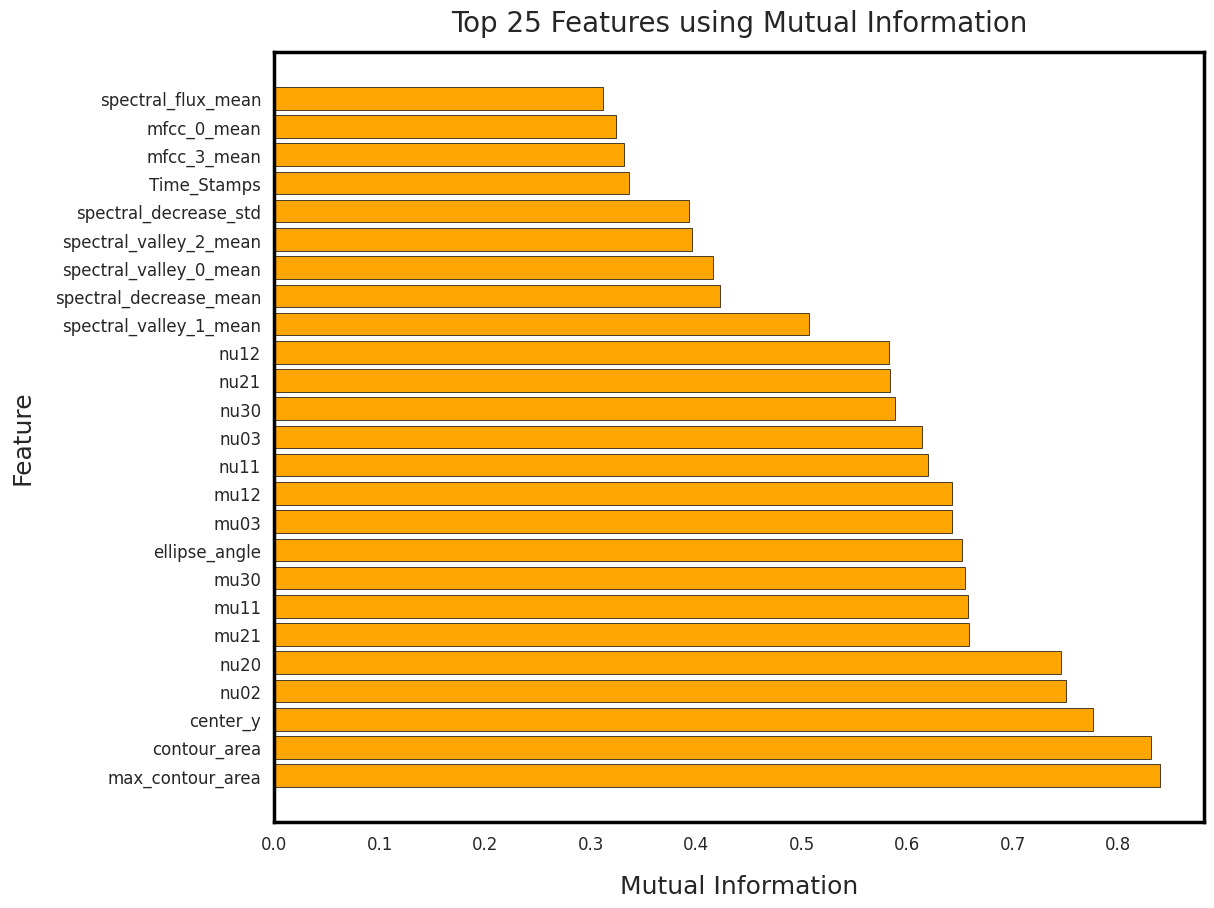

,feature,mi_value
78,max_contour_area,0.839509
94,contour_area,0.830974
93,center_y,0.775601
88,nu02,0.749968
86,nu20,0.745691
...,...,...
65,mfcc_6_std,0.003133
75,mfcc_11_std,0.002875
67,mfcc_7_std,0.001765
77,mfcc_12_std,0.000000


In [142]:
sorted_df = mutual_info_feature_importance(dataset, X, y, top_n=25)
sorted_df

In [143]:
# Function to filter features based on Mutual Information (MI) threshold
def filter_mi_features(mi_importance_df, mi_threshold):
    """
    Filter features based on a given Mutual Information (MI) threshold.
    
    Args:
    - mi_importance_df (pd.DataFrame): DataFrame containing features and their MI values.
    - mi_threshold (float): The MI threshold for feature selection.
    
    Returns:
    - filtered_features (list): List of features that have MI values greater than or equal to the threshold.
    - removed_features (list): List of features that have MI values smaller than the threshold.
    """
    # Filter the features
    significant_features = mi_importance_df[mi_importance_df['mi_value'] >= mi_threshold]['feature'].tolist()
    insignificant_features = mi_importance_df[mi_importance_df['mi_value'] < mi_threshold]['feature'].tolist()
    
    return significant_features, insignificant_features

In [145]:
significant_features, insignificant_features = filter_mi_features(sorted_df, mi_threshold=0.1)
print("Significant features: \n", significant_features, "\n")

print("Insignificant features: \n", insignificant_features)

Significant features: 
 ['max_contour_area', 'contour_area', 'center_y', 'nu02', 'nu20', 'mu21', 'mu11', 'mu30', 'ellipse_angle', 'mu03', 'mu12', 'nu11', 'nu03', 'nu30', 'nu21', 'nu12', 'spectral_valley_1_mean', 'spectral_decrease_mean', 'spectral_valley_0_mean', 'spectral_valley_2_mean', 'spectral_decrease_std', 'Time_Stamps', 'mfcc_3_mean', 'mfcc_0_mean', 'spectral_flux_mean', 'mfcc_1_mean', 'amplitude_envelope_std', 'rectangle_angle', 'spectral_valley_3_mean', 'spectral_complexity_mean', 'spectral_flux_std', 'spectral_complexity_std', 'spectral_skewness_mean', 'loudness_vickers', 'spectral_valley_4_mean', 'spectral_contrast_3_mean', 'spectral_kurtosis_mean', 'spectral_rolloff_mean', 'spectral_contrast_1_mean', 'spectral_valley_5_mean', 'spectral_energy_band_ratio_mean', 'zero_crossing_rate', 'spectral_crest_factor_std'] 

Insignificant features: 
 ['spectral_crest_factor_mean', 'spectral_strong_peak_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_strong_peak_mean'